In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plot
import torch.nn.functional as F

In [2]:
from datetime import datetime
import torchvision.transforms as transforms

In [3]:
transformer_train = torchvision.transforms.Compose([
  # transforms.ColorJitter(
  #    brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2
  # ),
  # transforms.RandomCrop(32, padding=4),
  # transforms.RandomHorizontalFlip(p=0.5),
  # transforms.RandomRotation(degrees=15),
  # transforms.RandomAffine(0, translate=(0.1, 0.1)),
  # transforms.RandomPerspective(),
  transforms.ToTensor()
  ]
)

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transformer_train,
    download=True
)

test_data = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.32MB/s]


In [5]:
K = len(set(train_dataset.targets))

In [8]:
K
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [6]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size
)

In [18]:
class RNN(nn.Module):
  def __init__(self, n_inputs, m_hidden, l_layers, k_outputs):
    super().__init__()
    self.D = n_inputs
    self.M = m_hidden
    self.L = l_layers
    self.K = k_outputs


    self.rnn = nn.LSTM(
        input_size=n_inputs,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )
    self.fc = nn.Linear(in_features=self.M, out_features=self.K)

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    out, _ = self.rnn(X, (h0, c0))
    out = self.fc(out[:,-1, :])
    return out


In [27]:
model = RNN(28, 128, 2, 10)
model.to(device)

RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [25]:

def batch_gd(model: nn.Module, criterion: nn.CrossEntropyLoss, optimizer: torch.optim.Adam, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t_0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs = inputs.to(device).view(-1, 28, 28)
      targets = targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    dt = datetime.now() - t_0

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs = inputs.to(device).view(-1, 28, 28)
      targets = targets.to(device)


      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    print(f"Epoch: {it}/{epochs}, Train loss: {train_loss:.4f}, Test loss {test_loss:.4f}")
    print(f"Train time {dt}")

  return train_losses, test_losses


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [29]:
epochs = 10
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs)

Epoch: 0/10, Train loss: 0.5613, Test loss 0.1634
Train time 0:00:09.222104
Epoch: 1/10, Train loss: 0.1301, Test loss 0.0849
Train time 0:00:08.879472
Epoch: 2/10, Train loss: 0.0837, Test loss 0.0775
Train time 0:00:08.708693
Epoch: 3/10, Train loss: 0.0615, Test loss 0.0680
Train time 0:00:09.132822
Epoch: 4/10, Train loss: 0.0503, Test loss 0.0557
Train time 0:00:09.168588
Epoch: 5/10, Train loss: 0.0410, Test loss 0.0497
Train time 0:00:09.177148
Epoch: 6/10, Train loss: 0.0359, Test loss 0.0854
Train time 0:00:09.714732
Epoch: 7/10, Train loss: 0.0336, Test loss 0.0545
Train time 0:00:09.235772
Epoch: 8/10, Train loss: 0.0274, Test loss 0.0430
Train time 0:00:08.889272
Epoch: 9/10, Train loss: 0.0236, Test loss 0.0374
Train time 0:00:08.705765


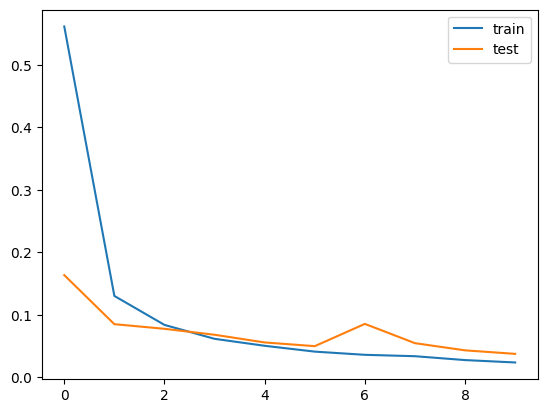

In [30]:
plot.plot(train_losses, label="train")
plot.plot(test_losses, label='test')
plot.legend()
plot.show()

In [32]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device).view(-1, 28, 28), targets.to(device)


  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device).view(-1, 28, 28), targets.to(device)

  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f} Test acc: {test_acc:.4f}")

Train acc: 0.9957 Test acc: 0.9946


In [33]:


from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="COnfusion Matrix",
                          cmap=plot.cm.Blues
                          ):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized")
  else:
    print("Not Normalized")
  print(cm)

  plot.imshow(cm, interpolation="nearest", cmap=cmap)
  plot.title(title)
  tick_marks = np.arange(len(classes))
  plot.xticks(tick_marks, classes, rotation=45)
  plot.xticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plot.text(j, i, format(cm[i,j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plot.tight_layout()
  plot.ylabel("True Label")
  plot.xlabel("Predicted Label")
  plot.show()

Not Normalized
[[ 970    0    0    2    0    1    6    0    0    1]
 [   0 1132    1    1    0    0    1    0    0    0]
 [   1    2 1021    2    2    0    1    2    1    0]
 [   0    0    2 1003    0    3    0    0    1    1]
 [   0    0    0    0  961    0    5    2    1   13]
 [   1    0    0    6    0  883    1    0    0    1]
 [   1    2    1    0    4    4  945    0    1    0]
 [   0    5    7    1    1    1    0 1005    2    6]
 [   0    0    1    2    0    3    4    1  963    0]
 [   0    0    0    0    7    0    0    2    2  998]]


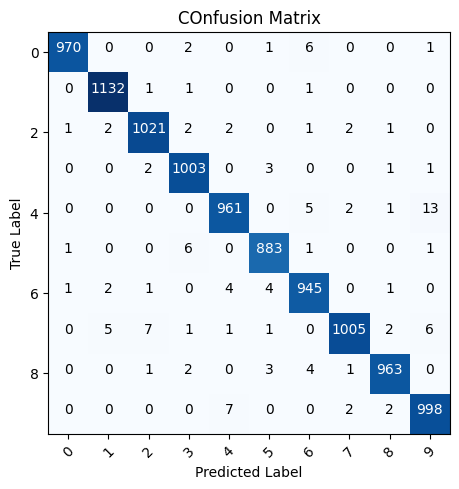

In [40]:
x_test = test_data.data.numpy()
y_test = test_data.targets.numpy()

p_test = np.array([])

for inputs, targets in test_loader:
  inputs = inputs.to(device).view(-1, 28, 28)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

Text(0.5, 1.0, 'True label: 7 Predicted: 2')

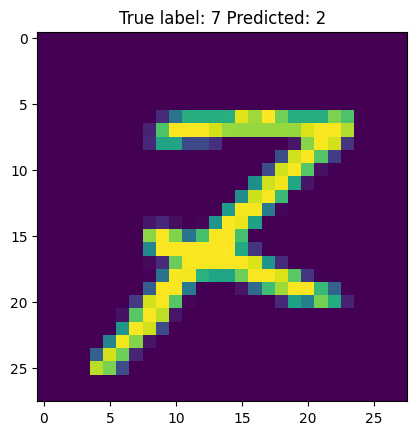

In [44]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx)

plot.imshow(x_test[sample_idx])
plot.title(f"True label: {y_test[sample_idx]} Predicted: {p_test[sample_idx]}")